<a href="https://colab.research.google.com/github/madhanmohans/Cross-Site-Scripting-Detection/blob/main/XSS_detection_%7C_Phase_2_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import itertools
import numpy as np
import pandas as pd
from nltk.util import ngrams
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense, Dropout, Activation, Lambda
# from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Embedding
from sklearn.metrics import accuracy_score
from keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("/content/Payloads.csv")

# Data preprocessing

In [ ]:
df.head()

,Payloads,Class
0,http://www.nwce.gov.uk/search_process.php?keyw...,Malicious
1,http://www.manchester.gov.uk/site/scripts/goog...,Malicious
2,http://www.ldsmissions.com/us/index.php?action...,Malicious
3,http://education.powys.gov.uk/english/adult_ed...,Malicious
4,http://www.northwarks.gov.uk/site/scripts/goog...,Malicious


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43219 entries, 0 to 43218
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Payloads  43218 non-null  object
 1   Class     43217 non-null  object
dtypes: object(2)
memory usage: 675.4+ KB


In [ ]:
df.shape

(43219, 2)

In [ ]:
# find duplicate rows

df[df.duplicated()].shape

(546, 2)

In [ ]:
# drop duplicate rows

df.drop(df[df.duplicated()].index, inplace=True)
df.shape

(42673, 2)

In [ ]:
pd.isnull(df).sum() # find null values

Payloads    1
Class       2
dtype: int64

In [ ]:
df = df.dropna() # drop null values

In [ ]:
pd.isnull(df).sum()

Payloads    0
Class       0
dtype: int64

In [ ]:
df['Class'].unique()

array(['Malicious', 'Benign', '1'], dtype=object)

In [ ]:
df.drop(df[(df['Class'] == '1')].index, inplace=True)

<ipython-input-13-9ecfd2b4fafc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[(df['Class'] == '1')].index, inplace=True)


In [ ]:
df['Class'].unique()

array(['Malicious', 'Benign'], dtype=object)

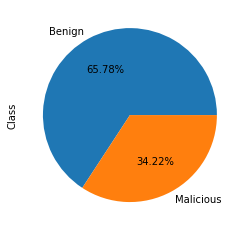

In [ ]:
df['Class'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.show()

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['Class']= label_encoder.fit_transform(df['Class']) 

In [ ]:
df['Class'].unique()

array([1, 0])

In [ ]:
X = df["Payloads"]
y = df["Class"]

# Model Building

In [ ]:
train, test = train_test_split(df, test_size = 0.3)

In [ ]:
max_features = 20000
maxlen = 150
nb_classes = 2

In [ ]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['Payloads'])

sequences_train = tokenizer.texts_to_sequences(train['Payloads'])
sequences_test = tokenizer.texts_to_sequences(test['Payloads'])

In [ ]:
y_train = np.array(train['Class'])
y_test = np.array(test['Class'])

In [ ]:
print('Pad sequences (samples x time)')
X_train = pad_sequences(sequences_train, maxlen=maxlen)
X_test = pad_sequences(sequences_test, maxlen=maxlen)
 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Pad sequences (samples x time)
X_train shape: (29868, 150)
X_test shape: (12801, 150)
y_train shape: (29868,)
y_test shape: (12801,)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Dense(64, activation='relu'))
model.add(LSTM(256, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

print('Train...')
callbacks = [EarlyStopping(patience=3), ReduceLROnPlateau(patience=2)]
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_test, Y_test), callbacks=callbacks)

train_score, train_accuracy = model.evaluate(X_train, Y_train, batch_size=128)
test_score, test_accuracy = model.evaluate(X_test, Y_test, batch_size=128)

Build model...
Train...
Epoch 1/20
234/234 [==============================] - 837s 4s/step - loss: 0.0631 - accuracy: 0.9773 - val_loss: 0.0131 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 2/20
234/234 [==============================] - 865s 4s/step - loss: 0.0151 - accuracy: 0.9963 - val_loss: 0.0111 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 3/20
234/234 [==============================] - 866s 4s/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0099 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 4/20
234/234 [==============================] - 871s 4s/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0091 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 5/20
234/234 [==============================] - 872s 4s/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0126 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 6/20
234/234 [==============================] - 875s 4s/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0106 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 7/20
101/101 [====================

In [ ]:
print('Train accuracy:', round(train_accuracy*100, 4), "%")
print('Test accuracy:', round(test_accuracy*100, 4), "%")

Train accuracy: 99.9665 %
Test accuracy: 99.7344 %


In [ ]:
from keras.models import save_model

save_model(model, 'LSTM-v1.h5')

In [ ]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))

model.add(LSTM(256, return_sequences=True, input_dim=3, input_shape =(50,), activation= 'softmax')) 
model.add(Dense(nb_classes))
model.add(Dropout(0.2))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')

model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test))

trainScore, trainAccuracy = model.evaluate(X_train, Y_train, batch_size=batch_size)
testScore, testAccuracy = model.evaluate(X_test, Y_test, batch_size=batch_size)


print('Train score:', trainScore)
print('Train accuracy:', trainAccuracy)

print('Test score:', testScore)
print('Test accuracy:', testAccuracy)